In [1]:
import mne

import numpy as np
import matplotlib.pyplot as plt
from mne import Epochs, pick_types
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.covariance import LedoitWolf, OAS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np


In [2]:



# Replace 'your_file.gbf' with the path to your GBF file
file_path = '../thesis_data/arne_03_05/Testdata_tt1.bdf'
# file_path = 'ly_04_07/Testdata_ly_imag_01.bdf'
# Load the BDF file
raw = mne.io.read_raw_bdf(file_path, preload=True)

# Print some information about the loaded data
print(raw.info)
# Print channel names
print(raw.ch_names)

# Specify the channel name you are interested in
channel_name = 'Status'  # Replace with the actual channel name

# Get the index of the specified channel
channel_index = raw.ch_names.index(channel_name)

# Get the data for the specified channel
channel_data = raw.get_data()[channel_index]

# Print unique values in the channel
unique_values = set(channel_data)
print("Unique values in channel '{}':".format(channel_name))
for value in unique_values:
    print("{}---{}".format(value,hex(int(value))))

# Specify the value you want to count
value_to_count = 128  # Replace with the value you want to count

# Count occurrences of the specified value using Python's count() function
count_python = channel_data.tolist().count(value_to_count)
print("Occurrences of value {} in channel '{}': {}".format(value_to_count, channel_name, count_python))
array_int = channel_data.astype(int)
channel_trigger = np.right_shift(array_int,5) & 0x7


Extracting EDF parameters from /Users/reniflalebenezer/thesis_data/arne_03_05/Testdata_tt1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 935935  =      0.000 ...   457.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 271 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2024-05-03 12:19:34 UTC
 nchan: 272
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 1 item (dict)
>
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C

In [3]:
# Specify the value you want to track changes for
value_to_track = 2  # Replace with the value you want to track changes for

# Initialize variables to keep track of changes
previous_value = channel_trigger[0]
change_instances = []

# Iterate through the data and track instances when the value changes
for i, value in enumerate(channel_trigger):
    if value != previous_value and value == value_to_track:
        change_instances.append((i, value))
    previous_value = value

# Print instances when the value changes
print("Instances when value {} changes in channel '{}': {} instances".format(value_to_track, channel_name, len(change_instances)))
for instance in change_instances:
    print("Index: {}, Value: {}".format(instance[0], instance[1]))

Instances when value 2 changes in channel 'Status': 41 instances
Index: 180781, Value: 2
Index: 185209, Value: 2
Index: 188669, Value: 2
Index: 188934, Value: 2
Index: 191392, Value: 2
Index: 194388, Value: 2
Index: 207046, Value: 2
Index: 223122, Value: 2
Index: 230498, Value: 2
Index: 236466, Value: 2
Index: 252587, Value: 2
Index: 272589, Value: 2
Index: 287142, Value: 2
Index: 318447, Value: 2
Index: 349491, Value: 2
Index: 371205, Value: 2
Index: 373987, Value: 2
Index: 374535, Value: 2
Index: 412775, Value: 2
Index: 445534, Value: 2
Index: 473031, Value: 2
Index: 474055, Value: 2
Index: 475470, Value: 2
Index: 479978, Value: 2
Index: 483918, Value: 2
Index: 503849, Value: 2
Index: 522366, Value: 2
Index: 547768, Value: 2
Index: 552466, Value: 2
Index: 552749, Value: 2
Index: 573216, Value: 2
Index: 603828, Value: 2
Index: 624839, Value: 2
Index: 646693, Value: 2
Index: 650347, Value: 2
Index: 653809, Value: 2
Index: 676637, Value: 2
Index: 705928, Value: 2
Index: 725159, Value: 2

In [4]:
# Define a list of channels you want to keep
channels_to_keep = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'A32', 'A31', 'A23','A8', 'A19', 'A1']

# Create a new raw object with only the specified channels
raw_specific_channels = raw.copy().pick(channels_to_keep)

# Define a mapping dictionary from original channel names to standard electrode names
channel_mapping = {
    'A32':'Cz', 
    'A31':'Fz', 
    'A23':'C4',
    'A8':'C3', 
    'A19':'P4', 
    'A1':'P3'
    # Add more mappings as needed
}

# Rename channels in your raw data using the mapping
raw_specific_channels.rename_channels(channel_mapping)





Measurement date,"May 03, 2024 12:19:34 GMT"
Experimenter,Unknown
Participant,arne
Digitized points,Not available
Good channels,12 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


In [5]:

# Initialize variables to keep track of changes
previous_value = channel_trigger[0]
all_events = []

# Iterate through the data and track instances when the value changes
for i, value in enumerate(channel_trigger):
    if value != previous_value and value != 0:
        all_events.append([i,0, value])
    previous_value = value




print(all_events)


[[177232, 0, 1], [180781, 0, 2], [180782, 0, 5], [181892, 0, 3], [185209, 0, 2], [185210, 0, 5], [186201, 0, 3], [188669, 0, 2], [188670, 0, 5], [188803, 0, 3], [188934, 0, 2], [188935, 0, 5], [189204, 0, 3], [190307, 0, 4], [190446, 0, 5], [191392, 0, 2], [191393, 0, 5], [193298, 0, 3], [194388, 0, 2], [194389, 0, 5], [198616, 0, 6], [199644, 0, 7], [203291, 0, 1], [203366, 0, 5], [205898, 0, 5], [205899, 0, 4], [206199, 0, 5], [207046, 0, 2], [207047, 0, 5], [211278, 0, 6], [212308, 0, 7], [215423, 0, 1], [215456, 0, 5], [217870, 0, 5], [217871, 0, 4], [218552, 0, 5], [218820, 0, 5], [218821, 0, 4], [219237, 0, 5], [219391, 0, 5], [219392, 0, 4], [219958, 0, 5], [220101, 0, 5], [220102, 0, 4], [220397, 0, 5], [220398, 0, 4], [220800, 0, 5], [220801, 0, 4], [221078, 0, 5], [221897, 0, 5], [221898, 0, 4], [222852, 0, 5], [223122, 0, 2], [223123, 0, 5], [225289, 0, 3], [227737, 0, 5], [229820, 0, 3], [230498, 0, 2], [230499, 0, 5], [230788, 0, 3], [235358, 0, 5], [235633, 0, 3], [236466

Using matplotlib as 2D backend.


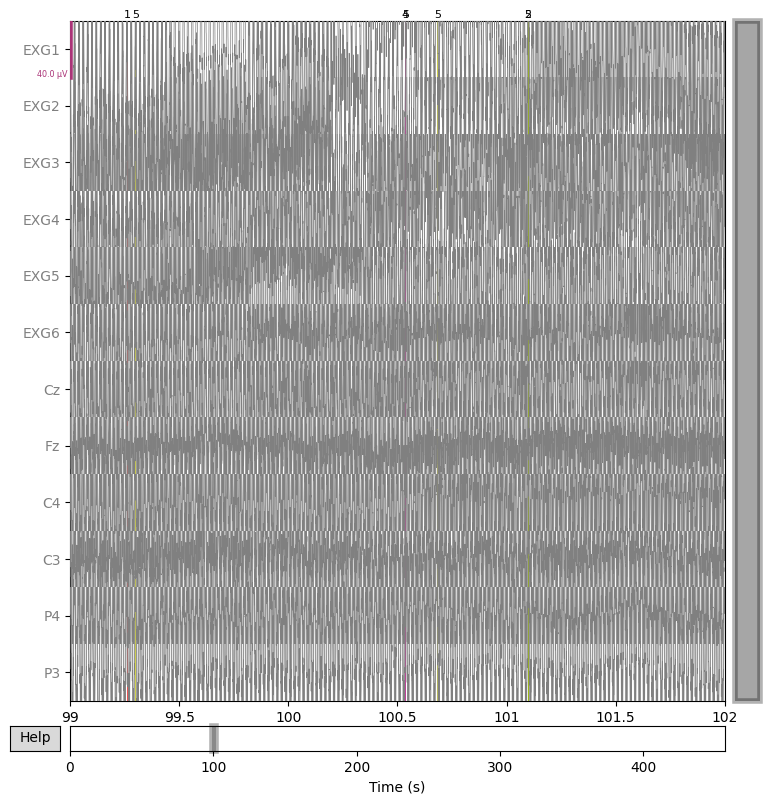

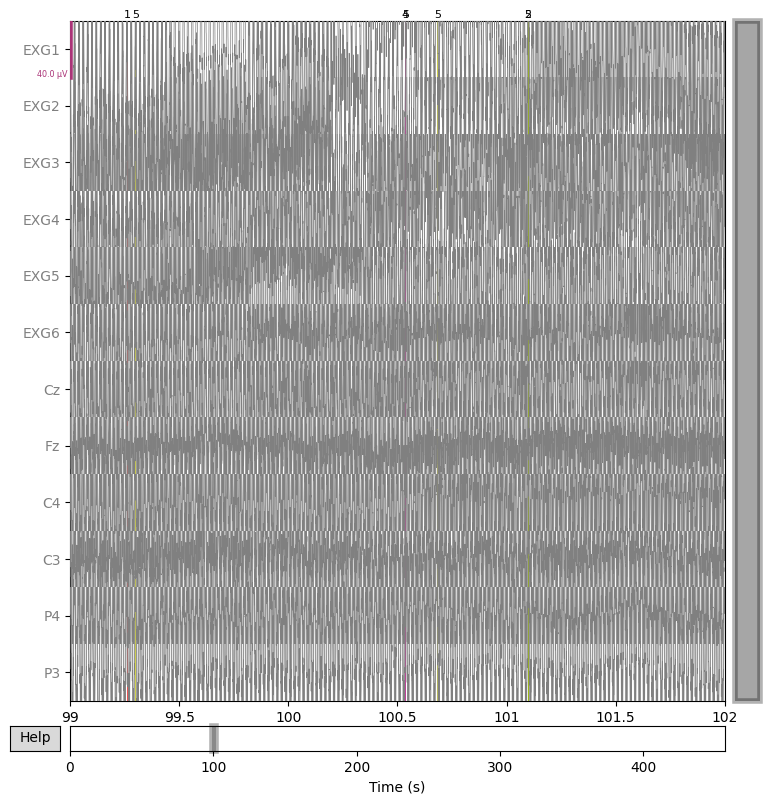

In [6]:
# Define event colors
event_color = {1: "r", 2: "g", 3: "b", 4: "m", 5: "y", 6: "k", 7: "c"}

# Plot the data with events
all_events_arr = np.asarray(all_events)
raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=3,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
    )


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


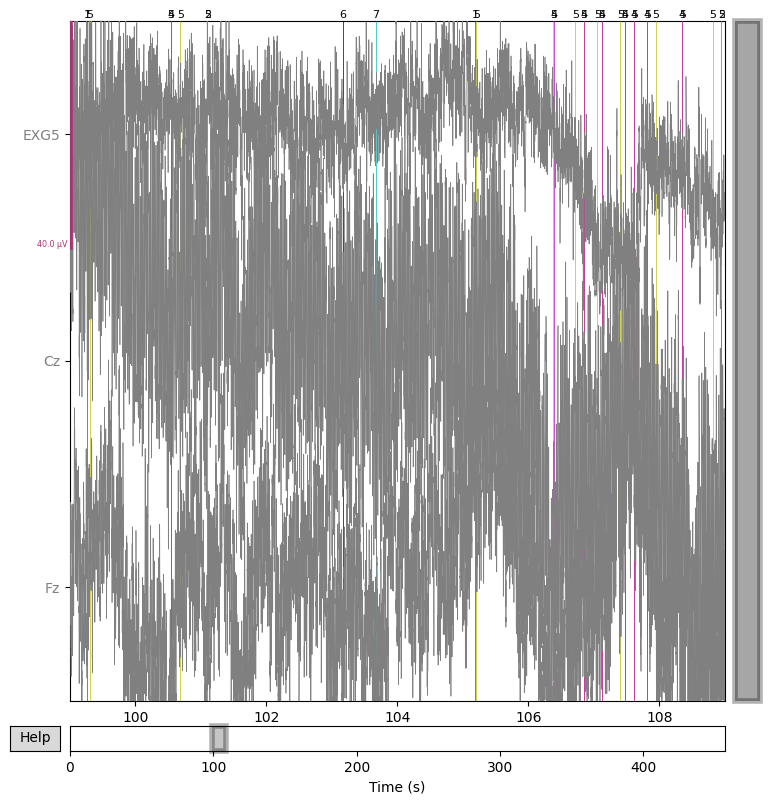

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (1.651 s)



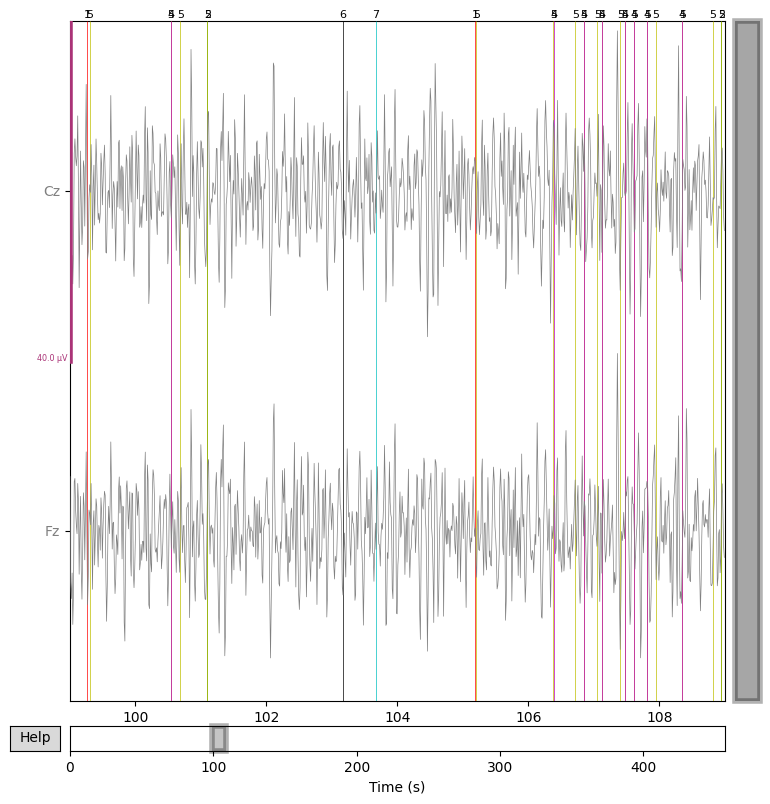

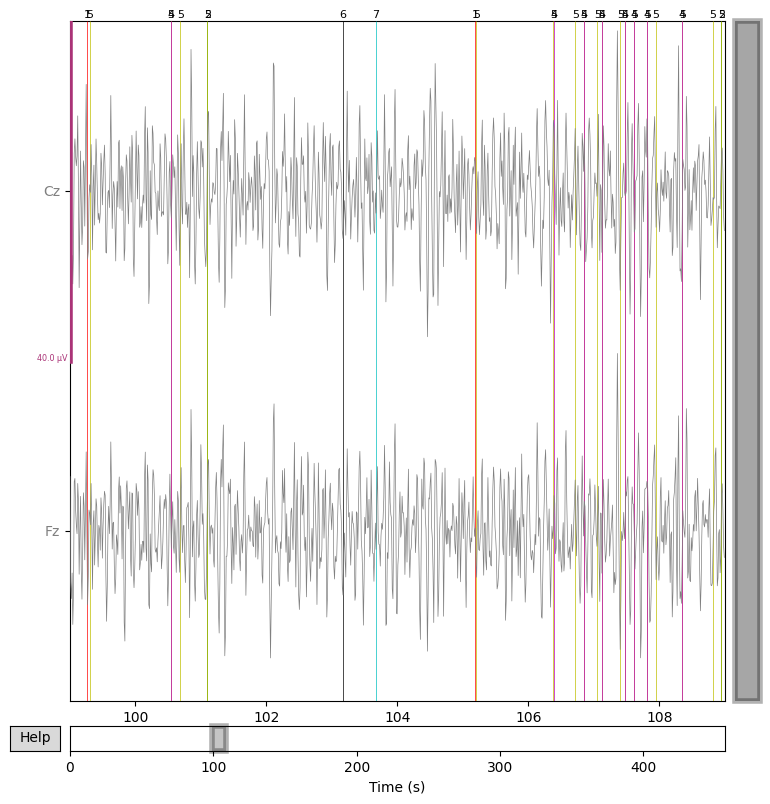

In [7]:
raw_specific_channels.set_eeg_reference(ref_channels=['EXG5','EXG6'])

raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=10,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
        picks=["Cz","Fz","EXG5"]
    )

raw_specific_channels.filter(7.0, 30.0, fir_design="firwin")
raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=10,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
        picks=["Cz","Fz"]
    )

In [8]:
raw_specific_channels.set_channel_types({'EXG1':'eog','EXG2':'eog','EXG3':'eog','EXG4':'eog'})

# Define a mapping dictionary from original channel names to standard electrode names
channel_mapping = {
    'EXG5':'A1', 
    'EXG6':'A2'
    # Add more mappings as needed
}

# Rename channels in your raw data using the mapping
raw_specific_channels.rename_channels(channel_mapping)

# Define event IDs for epochs of interest
event_id = {'event_1': 2, 'event_2': 4}  # Replace with your actual event IDs

# Define epoch parameters
tmin, tmax = -1.5, 0.5  # Start and end times in seconds

# Create epochs
epochs = mne.Epochs(raw_specific_channels, all_events, event_id, tmin, tmax, preload=True)

# Label epochs based on event ID
labels = epochs.events[:, -1]

Not setting metadata
234 matching events found
Setting baseline interval to [-1.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 234 events and 4097 original time points ...
0 bad epochs dropped


In [9]:
labels


array([2, 2, 2, 2, 4, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4,
       2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2])

In [10]:

def split_epochs_stratified_kfold(epochs, n_splits=5, random_state=None):
    data = epochs.get_data()
    labels = epochs.events[:, -1]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    splits = []
    
    for train_index, test_index in skf.split(data, labels):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        splits.append((X_train, X_test, y_train, y_test))
    
    return splits


# # Select epochs and labels for the events of interest
epochs_data = epochs.get_data()

# # Check for NaNs and Infs
# if np.isnan(epochs_data).sum() > 0 or not np.isfinite(epochs_data).all():
#     raise ValueError("Data contains NaNs or infinite values.")
    


# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
accuracies = []
true_pos = []
false_pos = []
true_neg = []
false_neg = []
splits = split_epochs_stratified_kfold(epochs, n_splits=5, random_state=42)
for X_train, X_test, y_train, y_test in splits:
    print(f"train_data_length = {len(X_train)}")
    print(f"test_data_length = {len(X_test)}")
    # Initialize CSP
    
    csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)

    # Create a classification pipeline with CSP and LDA
    clf = Pipeline([('CSP', csp), ('LDA', LDA())])

    # Train the classifier
    clf.fit(X_train, y_train)

    # Test the classifier
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    tp=0
    tn=0
    fp=0 
    fn=0
    for yt,yp in y_test,y_pred:
        if((yt==2)and(yt==2)):
            
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
average_accuracy = np.mean(accuracies)
print(f"average_accuracy - {average_accuracy}")



SyntaxError: invalid decimal literal (454412416.py, line 51)

In [ ]:
# # Check for NaNs and Infs
# if np.isnan(epochs_data).sum() > 0 or not np.isfinite(epochs_data).all():
#     raise ValueError("Data contains NaNs or infinite values.")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)


In [ ]:


montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [ ]:
print(raw_specific_channels.info)


In [ ]:
def conv_sample_to_time(sample_id):
    return sample_id/2048.0 
ignore_events_threshold = 1.5
cleaned_box_events = []
trial = 0;
previous_index_2 = 0
previous_index_4 = 0
# Iterate through the data and track instances when the value changes
for [i,x, value] in all_events:
    if value==1:
        cleaned_box_events.append([i,x, value])
        trial+=1
    elif value==7:
        cleaned_box_events.append([i,x, value])
    elif value==2:
        cleaned_box_events.append([i,x, value])
        previous_index_2 = i
    elif value==4:
        cleaned_box_events.append([i,x, value])
        previous_index_4 = i
    elif value==5:
        prev_time = conv_sample_to_time(previous_index)
        curr_time = conv_sample_to_time(i)
        time_diff = curr_time - prev_time
        if previous_value==4 and time_diff<ignore_events_threshold:
            cleaned_box_events.pop()
    elif value==3:
        prev_time = conv_sample_to_time(previous_index_2)
        curr_time = conv_sample_to_time(i)
        time_diff = curr_time - prev_time
        if time_diff<ignore_events_threshold:
            cleaned_box_events.pop()
    elif value==6:
        prev_time = conv_sample_to_time(previous_index_2)
        curr_time = conv_sample_to_time(i)
        time_diff = curr_time - prev_time
        if time_diff<ignore_events_threshold:
            cleaned_box_events.pop()

    previous_value = value
    previous_index = i

print(cleaned_box_events)


In [ ]:
# print(all_events[0:754])
# prev_time = conv_sample_to_time(777743)
# curr_time = conv_sample_to_time(777879)
# time_diff = curr_time - prev_time
# print(time_diff)

In [ ]:

# Create epochs
epochs = mne.Epochs(raw_specific_channels, cleaned_box_events, event_id, tmin, tmax, preload=True)

# Label epochs based on event ID
labels = epochs.events[:, -1]

accuracies =[]
splits = split_epochs_stratified_kfold(epochs, n_splits=5, random_state=42)
for X_train, X_test, y_train, y_test in splits:

    # Initialize CSP
    csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)

    # Create a classification pipeline with CSP and LDA
    clf = Pipeline([('CSP', csp), ('LDA', LDA())])

    # Train the classifier
    clf.fit(X_train, y_train)

    # Test the classifier
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
average_accuracy = np.mean(accuracies)
print(f"average_accuracy - {average_accuracy}")




In [ ]:
# print(len(channel_trigger))
# # Plotting the line chart
# plt.figure(figsize=(12, 8))
# plt.plot(channel_trigger[775936:785936], marker='s', linestyle='-', color='r', label='count_true_negative')

# # Adding titles and labels
# plt.title('Dwelltime VS count_true_positive/count_true_negative percentage', fontsize=16)
# plt.xlabel('Dwelltime', fontsize=14)
# plt.ylabel('Percentage', fontsize=14)
# plt.xticks(rotation=45)
# plt.legend()
# plt.grid(True)

# # Displaying the chart
# plt.show()